In [40]:
import sys
import warnings

import mplsoccer as mpl
import polars as pl
from statsbombpy import sb
import shap

sys.path.append("..")
sys.dont_write_bytecode = True
warnings.filterwarnings("ignore")

In [19]:
from utils.feature_engineering_handler import FeatureEngineeringHandler
from utils.passes_handler import PassesHandler
from utils.preprocessing_handler import PreprocessingHandler
from model.tuning import ModelCVEvaluator, ModelParamTuner
from model.train import ModelTrainer
from model.eval import ModelEval
from utils.utils import split_train_test, plot_correlations, plot_numerical_feature_distributions, plot_categorical_feature_distributions, plot_single_feature_distribution, plot_mutual_information, compute_generalisation_error_from_run_id_and_experiment_id, get_best_params_and_features_from_parent_run_id, get_registered_model 
from utils.statics import lightgbm_model_name, tracking_uri

model_type = lightgbm_model_name

# Modelling pass difficulties
I believe we can all agree that Pavard's half volley goal was a beautiful, but I the buildup to the goal is also really interesting to look into. Matuidi plays a through ball to Lucas Hernández who then plays a cross at a difficult angle back to Pavard, before he hits a half volley. While the half volley itself requires lots of technique (and luck), I want to answer the following about the passes:
1. Is there a way to quantify the difficulty of the two passes that lead up the goal (i.e. how likely are these types of passes to succeed?)
2. If yes, which pass was more difficult to make (has a lower probability of success)?

Fortunately, there are lots of data related to passes in the ``statsbombpy`` API which we can leverage to adopt a data-driven approach to answer our questions. The plan is to build a model that can tell us give us a pass difficulty score $p_\text{pass}$ for a pass from point $(x_1, y_1)$ to $(x_2, y_2)$ on the pitch. 

# Getting the data


In [3]:
wc2018_matches_df = sb.matches(competition_id=43, season_id=3).sort_values(
    "match_date", ascending=False
)
wc2018_matches = pl.from_pandas(wc2018_matches_df)
match_ids = wc2018_matches.select("match_id").to_series().to_list()

In [4]:
passes_handler = PassesHandler(match_ids=match_ids)
# passes_df = passes_handler.get_passes_from_match_ids()

Now that we have generated a .csv file, let us just simply load that.

In [5]:
passes_df = pl.read_parquet("../data/02-analysis/passes.parquet")

Let us now split the data into a train set and test set, so we only look at the training data.

In [6]:
train_df, test_df = split_train_test(passes_df=passes_df)

# Exploring the data
Let us take a quick look at the data and what each feature stands for according to the official [documentation](https://github.com/statsbomb/statsbombpy/blob/master/doc/Open%20Data%20Events%20v4.0.0.pdf):

- ``start_x``: x coordinate of the pass origin (where the pass started)
- ``start_y``: y coordinate of the pass origin
- ``end_x``: x coordinate of the pass destination (where the pass ended)
- ``end_y``: y coordinate of the pass destination
- ``length``: length of the pass in yards
- ``height``: the height type of the pass (e.g., Ground Pass, Low Pass, High Pass)
- ``angle``: angle of the pass in radians, with 0 pointing straight ahead. Values between 0 and $\pi$ indicating an angle clockwise, and negative values between 0 and $-\pi$ representing an angle anti-clockwise.
- ``duration``: the length the event lasted in seconds
- ``body_part``: which body part was used to make the pass (Head, Left foot, Right foot, Other)
- ``under_pressure``: Boolean indicating whether the player making the pass was under pressure by other players. Null if False.
- ``outcome``: result of the pass (e.g., Incomplete, Out, Pass offside, null if completed). This is our target variable.

There is also the ``match_id`` column, but we will not use that as an actual feature in our model. In regards to the coordinate system of the football pitch, the StatsBomb documentation defines the top left corner as the origin $(0,0)$ and the bottom right corner as $(120, 80)$ 

In [7]:
train_df.describe()

statistic,start_x,start_y,end_x,end_y,length,height,angle,duration,body_part,under_pressure,outcome
str,f64,f64,f64,f64,f64,str,f64,f64,str,f64,str
"""count""",61996.0,61996.0,61996.0,61996.0,61996.0,"""61996""",61996.0,61996.0,"""58803""",12894.0,"""12560"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,"""3193""",49102.0,"""49436"""
"""mean""",60.053229,40.37396,66.731934,40.198722,21.340367,null,0.026687,1.516974,null,1.0,null
"""std""",26.913721,24.038662,26.83367,23.802009,14.889273,null,1.559366,0.87322,null,null,null
"""min""",1.0,1.0,1.0,1.0,0.0,"""Ground Pass""",-3.120319,0.0,"""Drop Kick""",1.0,"""Incomplete"""
"""25%""",40.0,20.0,47.0,20.0,11.18034,null,-1.19029,0.947,null,null,null
"""50%""",59.0,40.0,66.0,40.0,17.464249,null,0.0,1.307,null,null,null
"""75%""",80.0,61.0,87.0,61.0,27.018513,null,1.2490457,1.84,null,null,null
"""max""",120.0,80.0,120.0,80.0,108.66922,"""Low Pass""",3.1415927,8.56,"""Right Foot""",1.0,"""Unknown"""


The ``null_count`` row tells us that the features ``body_part``, ``under_presssure`` and ``outcome`` have null values which will affect our choice of model.

In total, we have 10 features and the target variable. Out of the 10 features, 7 are continious, 2 are categorical and 1 is binary. Let us try to plot the correlation between the continious features.



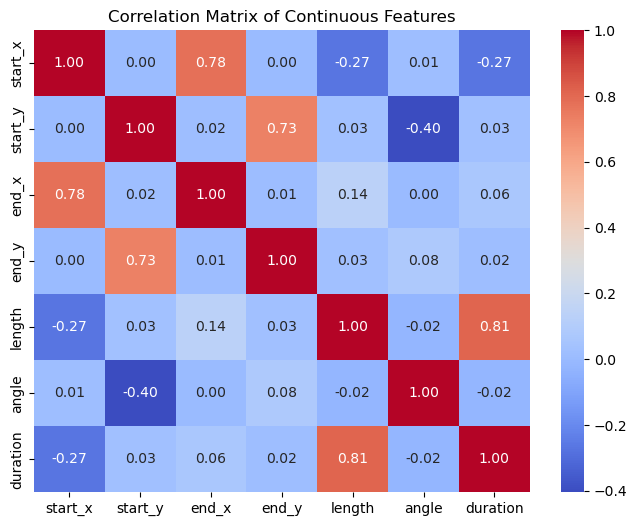

In [8]:
numerical_columns = [
    "start_x",
    "start_y",
    "end_x",
    "end_y",
    "length",
    "angle",
    "duration"
]

plot_correlations(train_df=train_df, numerical_cols=numerical_columns)

From the matrix plot, we can observe that ``duration`` and ``length`` are highly positively correlated. There is also a high correlation between ``start_x`` and ``end_x`` and ``start_y`` and ``end_y``. There is also a significant inverse relationship ``start_x`` with ``length`` and ``duration`` and ``start_y`` and ``angle``. If we are considering using linar models, such as logistic regression, it is important to handle the multicollinearity.

Now let us look at the distributions of the data and the null values in the columns ``body_part``, ``under_presssure`` and ``outcome``.

In [9]:
columns = train_df.columns
target_column = "outcome"
categorical_columns = [
    col for col in columns if col not in numerical_columns and col != target_column
]

print("Number of categorical Columns:", len(categorical_columns))
print("Number of Numerical Columns:", len(numerical_columns))

Number of categorical Columns: 3
Number of Numerical Columns: 7


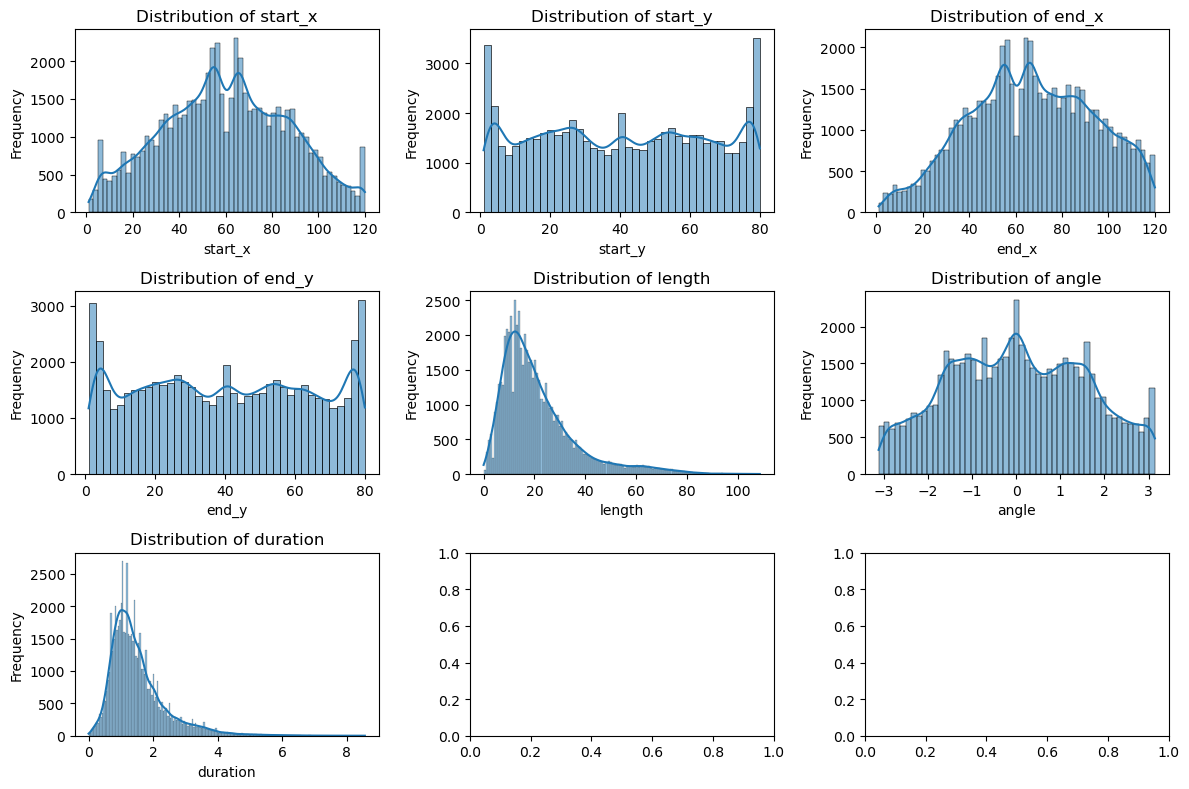

In [10]:
plot_numerical_feature_distributions(train_df=train_df, numerical_cols=numerical_columns)

We can observe that the distributions for ``length`` and ``duration`` are right-skewed, resembling gamma distributions. The features ``start_x`` and ``end_x`` are approximately Gaussian distributed, while ``start_y``, ``end_y`` seems to follow some bi-modal distribution with high frequencies at the at both extremes near 0 and 80. The distribution for  ``angle``seems to follow a tri-modal distribution with the mode at 0.

Let us now try to visualise the frequencies for the categorical columns. Due to how the data is, we need to perform some simple preprocessing.
- ``body_part``: According to the documentation, the body part is only recorded for "most" passes, which means data is missing at random. We introduce the class "Unknown" for replace null values.
- ``under_pressure``: True equals true, and null equals false. We therefore set null = False
- ``outcome``: According to the documentation, passes missing an outcome are "Completed". We binary encode this variable, as we want to distinguish between "Completed" and "Incompleted".

Note that this preprocessing is tempoary for now, and we will perhaps do something else when training the model.

In [11]:
preprocessing_handler = PreprocessingHandler(
    df=train_df, categorical_columns=categorical_columns
)
train_df_temp = preprocessing_handler.preprocess_categorical_columns()
train_df_temp = preprocessing_handler.preprocess_outcome_column()

2026-01-06 23:23:44,186 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-06 23:23:44,219 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


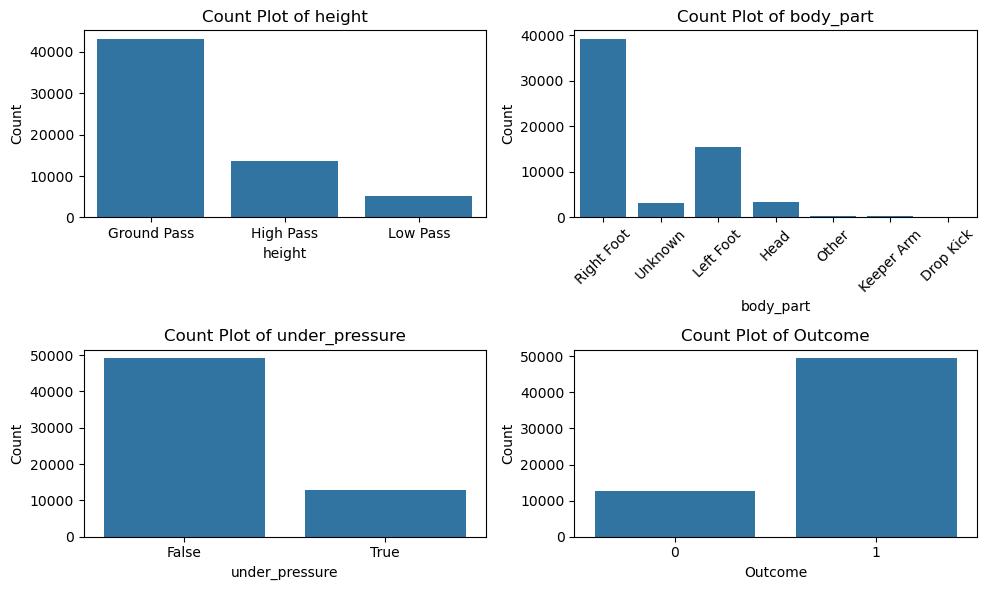

In [12]:
plot_categorical_feature_distributions(train_df=train_df_temp, categorical_cols=categorical_columns)

Let us look at the percentages for the feature ``under_pressure`` and the target ``outcome``.

In [13]:
train_df_temp.select(
    pl.col("under_pressure").value_counts(normalize=True),
    pl.col("outcome").value_counts(normalize=True),
)

under_pressure,outcome
struct[2],struct[2]
"{true,0.207981}","{1,0.797406}"
"{false,0.792019}","{0,0.202594}"


We observe that a large majority of passes were completed: Around 80% are completed with only 20% incompleted. Curiously, around 21% of the passes were made under pressure and 79% were not made under pressure. This is a pretty severe class imbalance for the target variable ``outcome`` which we will need to handle when splitting the dataset and perform stratified K-fold on the target variable ``outcome`` to ensure each fold contains the same proportions of completed and incompleted passes.

Another thing I like to do is to plot the mutual information to measure how each base feature reduces uncertainty about the target variable ``outcome`` before the feature engineering phase.

In [14]:
y_train = train_df_temp.select("outcome").to_series()
X_train_temp = train_df_temp.drop(pl.col("outcome"))

In [15]:
feature_engineering_handler = FeatureEngineeringHandler(X=X_train_temp)
X_train = feature_engineering_handler.encode_columns(columns=["height", "body_part"])

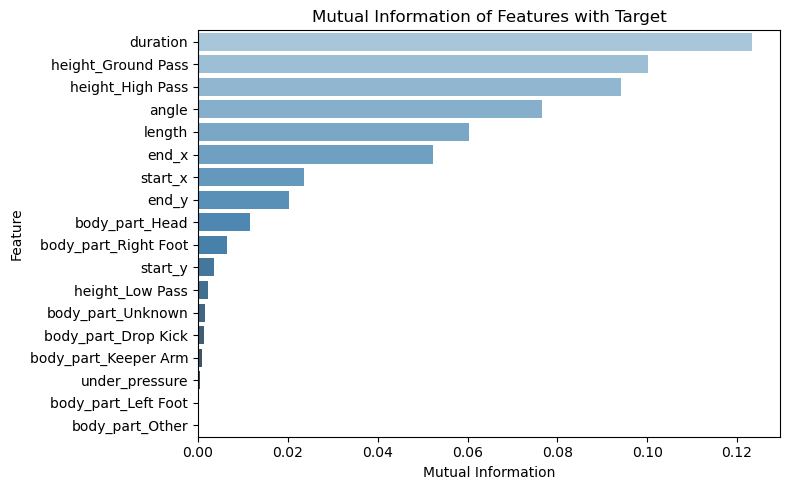

In [16]:
discrete_features = [False if col in numerical_columns else True for col in X_train.columns]
plot_mutual_information(X_train=X_train, y_train=y_train, discrete_features=discrete_features)

Ok, interesting. It seems the most important features contributing to the pass ``outcome`` is ``duration``, ``height``, ``angle`` and ``length``.  Among the coordinate features, ``end_x``, ``start_x``. ``end_y`` contribute much more to the mutual information than ``start_y``. In general the feature ``under_pressure`` and all ``body_part`` features contribute very little to the mutual information. 

Now we have a better idea on which features to focus on in the feature engineering phase.

# Training our first model
Let us train our first machine learning model to set a baseline. The training is as follows:
- Nested cross-validation where the inner loop is for hyperparameter tuning and feature selection, and outer loop is for model evaluation
- All training/evaluation is done using the cross-entropy loss function (also called log-loss for binary classificaiton)
- Hyperparameter tuning with Optuna
- Feature selection with RFECV
- Experiment logging in MLFlow

In [ ]:
run_name = f"baseline_nested_cv_tuning_and_train"
experiment_name = "Model evaluation with nested CV"
model_cv_evaluator = ModelCVEvaluator(model_type=model_type, n_inner_splits=5, n_outer_splits=10, n_trials=50, run_name=run_name, experiment_name=experiment_name)

In [ ]:
result_cv = model_cv_evaluator.get_generalisation_error(X_train=X_train, y_train=y_train)

In [20]:
compute_generalisation_error_from_run_id_and_experiment_id(parent_run_id="c7179bb82ab748558bc3be2fceb81172", experiment_id="416632419703074027")

95% confidence interval for best estimate of generalisation: nan ± nan


In [37]:
run_name = f"baseline_tuning_and_feature_selection_final"
experiment_name = "Model selection and hyperparameter tuning"
model_param_tuner = ModelParamTuner(model_type=model_type, n_inner_splits=5, n_trials=500, run_name=run_name, experiment_name=experiment_name)

In [ ]:
result_tuning = model_param_tuner.tune_and_train(X=X_train, y=y_train)

In [17]:
# best_params, best_features = get_best_params_and_features_from_parent_run_id("965b075a23d54168bf4cfde1fc902f76")
run_id = '8dcb28e3e44a4f018dd6402f7e788c07'
best_params, best_features = get_best_params_and_features_from_parent_run_id(run_id)

2026-01-06 23:23:50,743 - WARNING - Retrying (Retry(total=6, connect=6, read=7, redirect=7, status=7)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000026D92470F90>: Failed to establish a new connection: [WinError 10061] Der kunne ikke oprettes forbindelse, fordi destinationscomputeren aktivt nægtede det')': /api/2.0/mlflow/runs/get?run_uuid=8dcb28e3e44a4f018dd6402f7e788c07&run_id=8dcb28e3e44a4f018dd6402f7e788c07
2026-01-06 23:23:57,654 - WARNING - Retrying (Retry(total=5, connect=5, read=7, redirect=7, status=7)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000026D92472A10>: Failed to establish a new connection: [WinError 10061] Der kunne ikke oprettes forbindelse, fordi destinationscomputeren aktivt nægtede det')': /api/2.0/mlflow/runs/get?run_uuid=8dcb28e3e44a4f018dd6402f7e788c07&run_id=8dcb28e3e44a4f018dd6402f7e788c07
2026-01-06 23:24:07,902 - WARNING - Retrying (Retry(total=4, con

In [21]:
model_trainer = ModelTrainer(model_type=model_type, best_params=best_params, best_features=best_features, run_name="baseline_training", experiment_name="Final models")

In [22]:
# trained_model = model_trainer.train(X_train=X_train, y_train=y_train)
trained_model = get_registered_model(model_type=lightgbm_model_name, version="latest", model_registry_name="Final models_lightgbm")

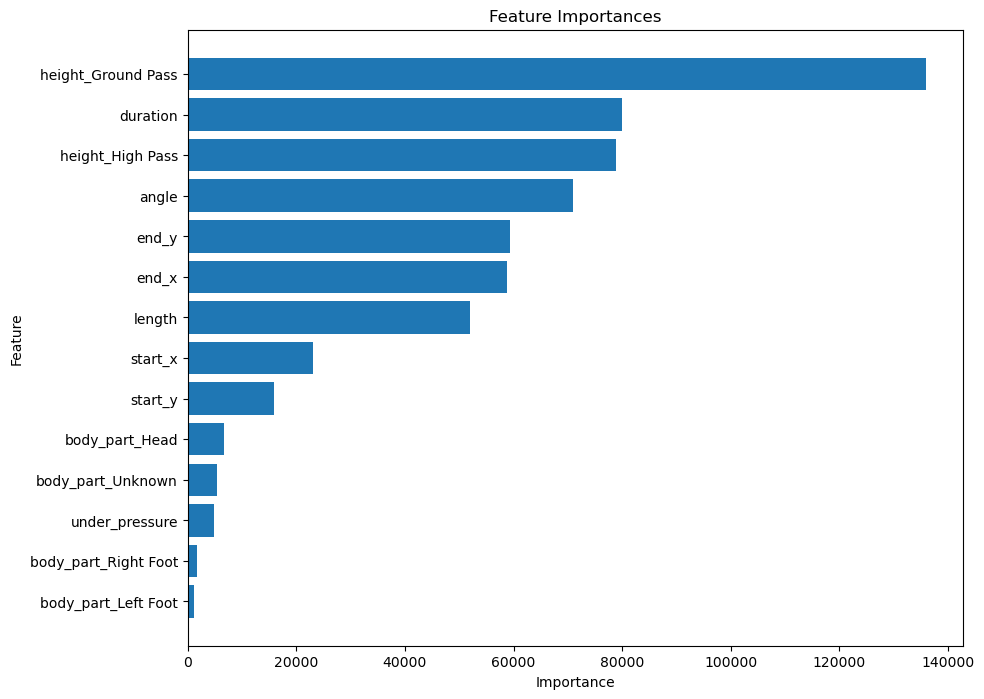

In [39]:
import pandas as pd

import matplotlib.pyplot as plt

# Get feature importances and corresponding feature names
feature_importances = trained_model.booster_.feature_importance(
    importance_type="gain"
)
feature_names = best_features

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()

Now let us do some testing

In [27]:
test_processing_handler = PreprocessingHandler(
    df=test_df, categorical_columns=categorical_columns)
test_df_temp = test_processing_handler.preprocess_categorical_columns()
test_df_temp = test_processing_handler.preprocess_outcome_column()
y_test = test_df_temp.select("outcome").to_series()
X_test_temp = test_df_temp.drop(pl.col("outcome"))

test_feature_engineering_handler = FeatureEngineeringHandler(X=X_test_temp)

X_test = test_feature_engineering_handler.encode_columns(columns=["height", "body_part"])

In [32]:
X_test

start_x,start_y,end_x,end_y,length,angle,duration,under_pressure,height_Ground Pass,height_High Pass,height_Low Pass,body_part_Drop Kick,body_part_Head,body_part_Keeper Arm,body_part_Left Foot,body_part_Other,body_part_Right Foot,body_part_Unknown
f64,f64,f64,f64,f64,f64,f64,bool,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
60.0,42.0,33.0,55.0,29.966648,2.6928694,2.04,false,1,0,0,0,0,0,1,0,0,0
40.0,53.0,87.0,65.0,48.507732,0.249979,2.206,false,0,1,0,0,0,0,0,0,1,0
31.0,21.0,86.0,22.0,55.00909,0.01818,2.72,false,0,1,0,0,0,0,0,0,1,0
37.0,55.0,45.0,75.0,21.540659,1.19029,1.04,false,0,0,1,0,0,0,0,0,1,0
47.0,75.0,28.0,73.0,19.104973,-3.036716,1.466,false,0,1,0,0,0,0,0,0,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3.0,38.0,23.0,19.0,27.58623,-0.759763,1.68,false,1,0,0,0,0,0,0,0,1,0
44.0,36.0,82.0,68.0,49.67897,0.6998929,2.28,false,0,1,0,0,0,0,0,0,1,0
81.0,60.0,101.0,30.0,36.05551,-0.982794,1.12,false,0,1,0,0,0,0,1,0,0,0


In [44]:
explainer = shap.TreeExplainer(trained_model)
shap_values = explainer.shap_values(X_test.select(best_features).to_pandas())

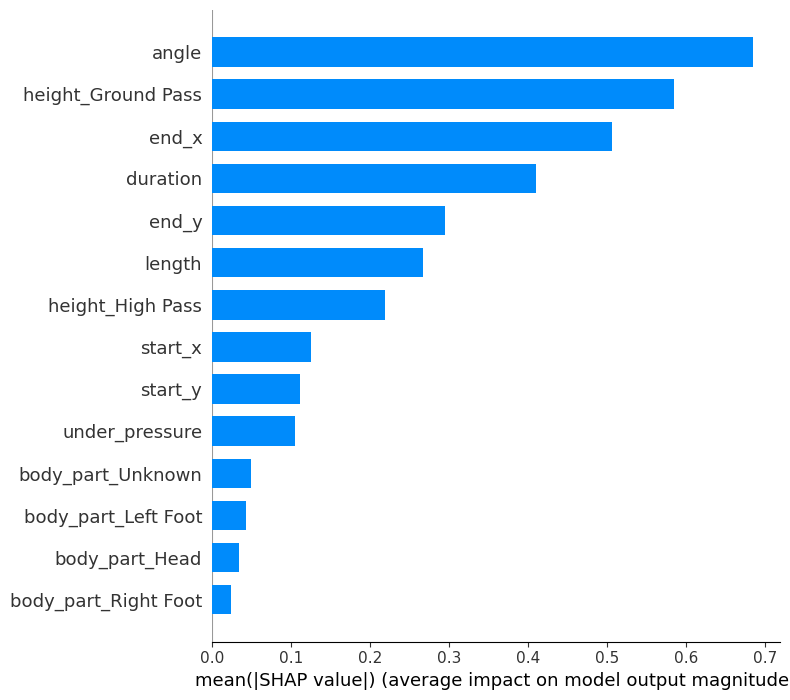

In [49]:
# This calculates the mean absolute SHAP value for each feature
shap.summary_plot(shap_values, X_test.select(best_features).to_pandas(), plot_type="bar", max_display=20)

In [22]:
model_evaluator = ModelEval(model=trained_model, best_features=best_features, experiment_name="Evaluation")


In [23]:
model_evaluator.eval(X_test=X_test, y_test=y_test)

2026-01-06 22:41:45,184 - INFO - Starting evaluation for LGBMClassifier with the following configuration: 
2026/01/06 22:41:45 INFO mlflow.tracking.fluent: Experiment with name 'Evaluation' does not exist. Creating a new experiment.
2026-01-06 22:41:45,861 - INFO - ROC AUC=0.9311 | Acc=0.9028 | Precision=0.9238 | Recall=0.9617 | F1=0.9424


🏃 View run LGBMClassifier at: http://127.0.0.1:8080/#/experiments/220281539845020993/runs/ea40d6f307464cf4bb8d20789ee5c2c9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/220281539845020993


Wow, pretty nice! An accuracy of 0.9028 percentage, that is pretty nice. But how can we do better? 

The answer: feature engineering. In most cases right now, we just 

# Feature engineering
Let us continue with some feature engineering phase where our goal is to make the data more "understandable" for our machine learning model. For our model, we will start by using a XGBClassifier model from XGBoost, since it offers a lot of neat advantages:
- General good performance on tabular machine learning problems with fast train/inference.
- Tree-based model, meaning it handles null values and features of different scales

What I want to do first is convert the length from yards to meter, since I am more familiar with the SI unit for length. The following formula can be used:
$$
\text{meter} = 0.9144 \cdot {yard}
$$


In [24]:
X_train = feature_engineering_handler.preprocess_length_column()

This transfomration just scales the length, so the distribution of ``length`` feature is still the same.

Now let us do something exciting: creating a new feature called velocity:
$$
\text{velocity} = \frac{\text{distance}}{\text{duration}}
$$
It turns out that there are three rows in the train data where duration is $0$, resulting in an infinite velocity. However, we will interpret this as "the pass was intercepted immediately" and therefore set the velocity to $0$ as well. Since both the ``duration`` and ``length`` features are quite right-skewed, we will also log the velocity to hopefully lessen the influence of outlier values using the ``log1p`` transformation: 
$$
\log(1 + x)
$$

In [25]:
X_train = feature_engineering_handler.preprocess_log_velocity_column()

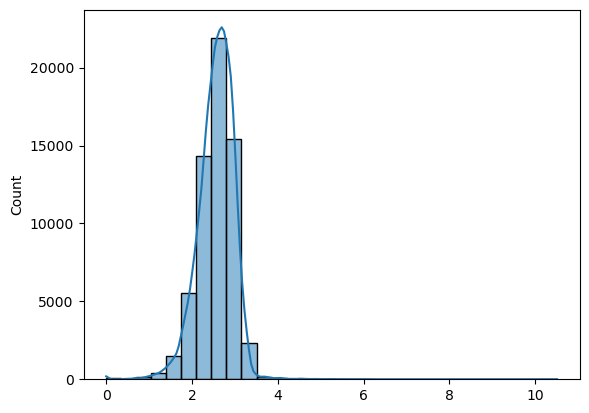

In [26]:
plot_single_feature_distribution(train_df=X_train, col="log_velocity")

To fix the skewness for the ``length`` and ``duration`` features, we also log1p transform these features.

In [27]:
X_train = feature_engineering_handler.preprocess_columns_with_log1p()

The ``angle`` feature has values in the range $[-\pi, \pi]$. However, according to the documentation $-\pi$ and $\pi$ represent the same direction, but value wise they are very different. We fix this by introducing two new features ``angle_sin`` and ``angle_cos`` which are just the sine and cosine values of the ``angle``. This way we can represent $-\pi$ and $\pi$ as the same angle value wise.

In [28]:
X_train = feature_engineering_handler.preprocess_angle_column()

Finally, let us engineer the features for ``x_start``, ``y_start``, ``x_end`` and ``y_end``- We will combine the x and y features into $\Delta x = x_\text{end} - x_\text{start}$ and $\Delta y = y_\text{end} - y_\text{start}$, representing the directional change in the x and y-direction. 

In [29]:
X_train = feature_engineering_handler.preprocess_direction_columns()